# Libraries

In [38]:
# Basics
import pandas as pd
import numpy as np
import os
from pathlib import Path
from jupyterthemes import jtplot
jtplot.style(theme='monokai')
from tabulate import tabulate
import warnings
warnings.filterwarnings('ignore')
from datetime import datetime  
from datetime import timedelta 
import pickle

# PLotting
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Scipy
from scipy import stats

# Tensorflow keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, GRU, Embedding
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from tensorflow.keras.backend import square, mean

# Scikit-learn
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn import preprocessing, metrics
from sklearn.ensemble import ExtraTreesClassifier, RandomForestRegressor
from sklearn.datasets import load_digits
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.datasets import make_regression
from sklearn.model_selection import RepeatedKFold
from sklearn.feature_selection import SelectKBest, mutual_info_regression, SelectFromModel
from sklearn.linear_model import LinearRegression, LogisticRegression, BayesianRidge, LassoLars
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

# Load Data

In [2]:
def load_stock_data(ticker, interval):
    """
    This function load stock data from Database files by first changing the working directory, loading the data and reset the working directory to the original path
    
    Parameters
    ----------
    ticker : str
        a string that describes the stock ticker, as listed in the file name
    interval : str
        an interval string according to the existing files in the databases
    """
    # Record original working directory
    owd = os.getcwd()
    # Change directory
    os.chdir('C:\\Users\\asus\\Documents\\Python Projects\\Trading - Research and Backtest\\'+ticker+'\\Databases\\')
    datapath = os.getcwd()+'\\'
    # Record all available files
    files = []
    for (dirpath, dirname, filenames) in os.walk(datapath):
        files.extend(filenames)
        break
    # Import as dataframe  
    df = pd.read_csv(datapath+ticker+'-'+interval+'.csv', parse_dates=True, index_col='Datetime')
    # Return working directory to original
    os.chdir(owd)
    return df

In [3]:
# Load data
interval = '5min' # Choose interval
# Load AAPL
df_aapl = load_stock_data('AAPL', interval=interval)
print('AAPL-'+interval+'\n', tabulate(df_aapl.tail(), headers='keys'))
print('\n')
# Load SPY
df_spy = load_stock_data('SPY', interval=interval)
print('SPY-'+interval+'\n', tabulate(df_spy.tail(), headers='keys'))

AAPL-5min
 Datetime               Open    High     Low    Close    Adj Close    Volume    Dividends    Stock Splits
-------------------  ------  ------  ------  -------  -----------  --------  -----------  --------------
2020-09-08 19:35:00  112.15  112.18  112.05   112.07       112.07         0            0               0
2020-09-08 19:40:00  112.1   112.45  112.07   112.32       112.32         0            0               0
2020-09-08 19:45:00  112.32  112.39  112.24   112.35       112.35         0            0               0
2020-09-08 19:50:00  112.34  112.6   112.26   112.55       112.55         0            0               0
2020-09-08 19:55:00  112.55  112.66  112.4    112.48       112.48         0            0               0


SPY-5min
 Datetime               Open    High     Low    Close    Adj Close    Volume    Dividends    Stock Splits
-------------------  ------  ------  ------  -------  -----------  --------  -----------  --------------
2020-09-08 19:35:00  332     332

In [122]:
# Merge Data
start_date = '2020-08-25'
start_time = '09:30'
end_time = '16:00'
df = pd.merge(df_aapl.between_time(start_time, end_time).loc[start_date:].drop(columns=['Close', 'Dividends', 'Stock Splits']),
                    df_spy.between_time(start_time, end_time).loc[start_date:].drop(columns=['Close', 'Dividends', 'Stock Splits']),
                    left_index=True, right_index=True
                    )
df.rename(columns={'Open_x': 'Open_AAPL', 'High_x': 'High_AAPL', 'Low_x': 'Low_AAPL', 'Adj Close_x': 'Close_AAPL', 
                         'Volume_x': 'Volume_AAPL', 'Open_y': 'Open_SPY', 'High_y': 'High_SPY', 'Low_y': 'Low_SPY', 
                         'Adj Close_y': 'Close_SPY', 'Volume_y': 'Volume_SPY'}, inplace=True)
print('df', '\n')
print(tabulate(df.tail(), headers='keys'))

df 

Datetime               Open_AAPL    High_AAPL    Low_AAPL    Close_AAPL    Volume_AAPL    Open_SPY    High_SPY    Low_SPY    Close_SPY    Volume_SPY
-------------------  -----------  -----------  ----------  ------------  -------------  ----------  ----------  ---------  -----------  ------------
2020-09-08 15:40:00       113.81       114         113.63        113.69    2.65195e+06      334.76      335.14     334.53       334.75   1.81996e+06
2020-09-08 15:45:00       113.67       113.72      113.12        113.4     4.47445e+06      334.76      334.86     333.72       334.4    3.37812e+06
2020-09-08 15:50:00       113.4        113.58      113.1         113.14    4.30381e+06      334.39      334.39     333.28       333.59   3.51848e+06
2020-09-08 15:55:00       113.15       113.35      112.68        112.92    8.28585e+06      333.59      333.72     332.88       333.26   9.27231e+06
2020-09-08 16:00:00       112.92       115.76      112.82        112.98    0                333.27   

# Data Manipulation

## Shift Data

In [123]:
# Calculate Returns
# Percentage Difference
df['Return_AAPL'] = (df['Close_AAPL'] - df['Close_AAPL'].shift(1)) / df['Close_AAPL'].shift(1)
df['Return_SPY'] = (df['Close_SPY'] / df['Close_SPY'].shift(1)) / df['Close_SPY'].shift(1)
# Shift all data
# df = df.shift(1)
df.dropna(inplace=True)

In [124]:
# Shift Data
# Target
df_target = df[['Return_AAPL']].iloc[1:]
df_target.columns = ['Return_AAPL_y']

# Everything else
df_features = df.shift(1)
df_features.dropna(inplace=True)

In [269]:
# Merge
df_concat = pd.concat([df_features, df_target], axis=1)
conditions = [df_concat['Return_AAPL_y'] > 0,
              df_concat['Return_AAPL_y'] < 0]
choices = ['Up', 'Down']
df_concat['Directions_y'] = np.select(conditions, choices, default='Same')
target_signal = ['Directions_y']
df_concat.drop(columns=['Return_AAPL_y'], inplace=True)

## Feature Selections

In [267]:
# Encode Data
# Data has to be coded for the algorithm to work
df_coded = df_concat.copy() # Make a copy of dataset
for column in df_coded.columns:
    encode = preprocessing.LabelEncoder() # Individual column encoder
    df_coded[column] = encode.fit_transform(df_coded[column]) # Encode column, replace df_coded with coded data

### SelectFrom

In [272]:
X, y = np.array(df_concat.drop(columns=target_signal)), np.array(df_concat[target_signal])
# selector = SelectFromModel(estimator=LogisticRegression()).fit(X, y)
selector = SelectFromModel(estimator=ExtraTreesClassifier(criterion='entropy')).fit(X, y)
select_from_feature = list(df_concat.drop(columns=target_signal).columns[selector.get_support(True)])

In [273]:
select_from_feature

['High_AAPL',
 'Low_AAPL',
 'Volume_AAPL',
 'Open_SPY',
 'Volume_SPY',
 'Return_AAPL']

In [250]:
_train = df_concat.iloc[:-20]
_test = df_concat.iloc[-20:]

In [188]:
# 'K' Optimiztion
find_kmean = np.array(df_concat['Return_AAPL_y']).reshape(-1, 1)
sil = [] # To store silhouette score
kmax = 10
kmin = 2
for k in range(kmin, kmax+1):
    kmean = KMeans(n_clusters = k).fit(find_kmean)
    labels = kmean.labels_
    sil.append(silhouette_score(find_kmean, labels, metric = 'euclidean'))
kmean_all = pd.Series(sil[kmin:], index = range(kmin, kmax-(kmin-1)))
optimized_k = kmean_all[kmean_all == kmean_all.max()].index[0]
print('Suggested K: ', optimized_k)

Suggested K:  2


In [256]:
# Kmeans cluster creation
find_kmean = np.array(df_concat)
kmean = KMeans(n_clusters=5)
kmean.fit(find_kmean)
df_concat['Kmeans'] = kmean.labels_ # Add new column to df_concat
# _center = []
# for label in df_concat['Kmeans']:
#     _center.append(float(kmean.cluster_centers_[label]))
# df_concat['Cluster_center'] = _center

In [257]:
# Kmeans cluster creation
find_kmean = np.array(_train)
kmean = KMeans(n_clusters=5)
kmean.fit(find_kmean)
_train['Kmeans'] = kmean.labels_ # Add new column to df_concat

In [258]:
kmean.predict(np.array(_test))

ValueError: Incorrect number of features. Got 13 features, expected 14

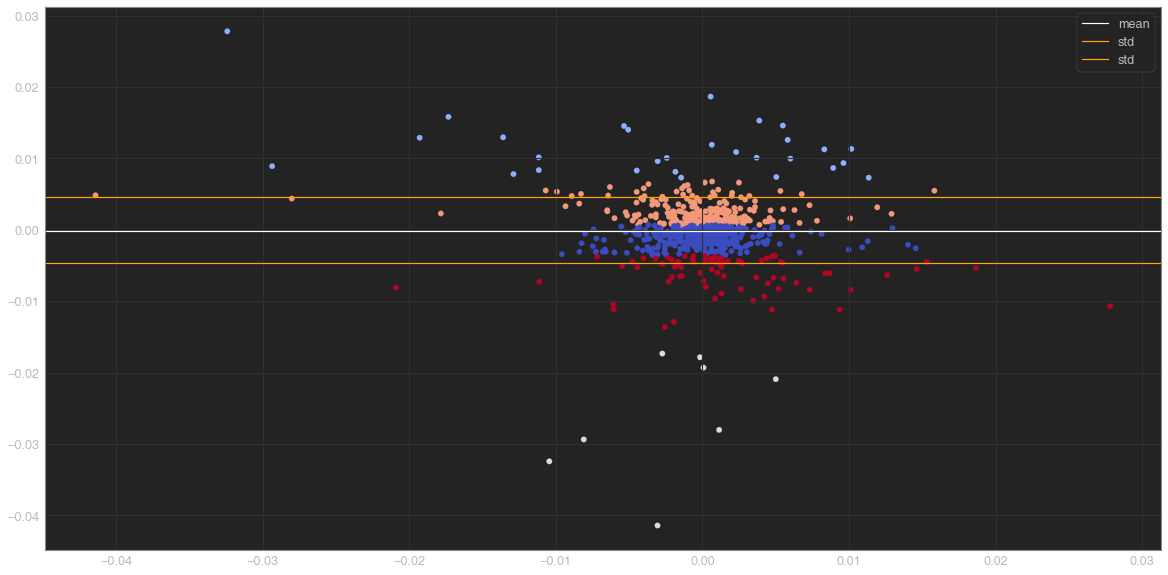

In [233]:
plt.figure(figsize=(20, 10))
plt.scatter(df_concat['Return_AAPL'], df_concat['Return_AAPL_y'], c=df_concat['Kmeans'], cmap='coolwarm')
plt.axhline(y=df_concat['Return_AAPL_y'].mean(), color='white', label='mean')
plt.axhline(y=df_concat['Return_AAPL_y'].std(), color='orange', label='std')
plt.axhline(y=-df_concat['Return_AAPL_y'].std(), color='orange', label='std')
plt.legend()

In [234]:
_ = []
for x in df_concat['Kmeans'].unique():
    _max = df_concat[df_concat['Kmeans']==x]['Return_AAPL_y'].max()
    _min = df_concat[df_concat['Kmeans']==x]['Return_AAPL_y'].min()
    _.append(df_concat[])

0
4
3
1
2


In [209]:
df_concat[df_concat['Kmeans']==0]['Return_AAPL_y'].max()

-0.0022035419897167715